***
** Algorithmes d'optimisation -- L3 MINT et doubles licences 2017/2018 -- Université Paris-Sud **
***

$\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\nr}[1]{\|#1\|}
\newcommand{\abs}[1]{|#1|}
\newcommand{\eps}{\varepsilon}
\newcommand{\sca}[2]{\langle#1|#2\rangle}
\newcommand{\D}{\mathrm{D}}
\newcommand{\hdots}{\dots}
\newcommand{\cond}{\mathrm{cond}}$

On commence par importer quelques fonctions des TP précédents.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# la commande suivante agrandit les figures
plt.rcParams['figure.figsize'] = [9.,6.]

def backtrack(f,x,d,m,alpha=0.3,beta=0.5):
    t = 1
    while f(x+t*d) > f(x) + alpha*t*m:
        t = beta*t
    return t

def gradient_backtracking(f,g,x0,err=1e-6,maxiter=500):
    x = x0.copy()
    fiter = []
    giter = []
    k = 0 # nombre d'itérations
    while(True): 
        k = k+1
        if k > maxiter: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        d = -g(x)
        fiter.append(f(x))
        giter.append(np.linalg.norm(d))
        if np.linalg.norm(d) <= err:
            break
        t = backtrack(f,x,d,-np.linalg.norm(d)**2)
        #if k%10==0: # on affiche des informations toute les 20 itérations
        #    print('iteration %d: f=%f, |g|=%f, step=%f' % (k, f(x), np.linalg.norm(d),t))
        x = x + t*d
    return x,np.array(fiter),np.array(giter)

def check_gradient(f,g,x0):
    N = len(x0)
    gg = np.zeros(N)
    for i in range(N):
        eps = 1e-4
        e = np.zeros(N)
        e[i] = eps
        gg[i] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numerique dans le calcul du gradient: %g (doit etre petit)' % np.linalg.norm(g(x0)-gg))

# TP 4: Pénalisation et gradient projeté

## Partie I: Problème d'obstacle

On considère un système physique constitué d'une chaine de $N+1$ ressorts. Les deux extrémités du $i$ème ressort ($0\leq i\leq N$ sont les points $(t_i,x_i) \in\Rsp^2$ et $(t_{i+1},x_{i+1}) \in \Rsp^2$, où $t_i = hi$ est fixé.  On considère également que la chaine est fixée à ses extrémités: $x_0 = x_{N+1} = 0$. Il reste donc $N$ inconnues $x = (x_1,\hdots,x_N)\in \Rsp^N$. L'énergie du système est donnée par la formule suivante:

$$J(x) = J(x_1,\hdots,x_N) = \frac{1}{2}\sum_{0\leq i\leq N-1} \nr{x_{i+1} - x_i}^2 $$ 

où l'on a donc fixé $x_0 = x_{N+1} = 0$. On pose un obstacle sous la chaîne de ressort, qui force chacune des coordonnées $x_i$ a être minorée par une constante $f_i$ (on peut penser à une main qui pousse le ressort par exemple). On arrive dont au problème d'optimisation

$$ \min_{x\in K} J(x) \hbox{ où } K = \{x\in \Rsp^N \mid \forall 1\leq i\leq N, x_i \geq f_i \}. $$

Nous allons la résolution numérique de ce problème d'optimisation par la méthode de gradient projeté. On rappelle les formules suivantes, issues du TD:

- La projection d'un point $y\in\Rsp^d$ sur le convexe fermé $K$ est donnée par 

$$ p_K(y) = (\max(y_N,f_N),\hdots,\max(y_N,f_N)) $$

- On admet que la fonction $J$ peut être mise sous la forme

$$ J(x) = \frac{1}{2} \sca{x}{Q x}  \hbox{ où } Q = \begin{pmatrix}2 & -1  & 0 &\cdots & 0 \\
-1 & 2 & -1 & \ddots & \vdots   \\ 
0 & \ddots & \ddots & \ddots& \vdots \\
\vdots & \ddots & -1 & 2 & -1 \\
0 & \hdots & 0 & -1 & 2
\end{pmatrix}$$

Le gradient de la fonction  $J$ en $x\in \Rsp^N$ est alors donné par $\nabla J(x) = Q x.$

**Q1)** Écrire une fonction projK(x) retournant la projection de $x\in \Rsp^N$ sur $K$ (la tester avec des petites valeurs de $N$). On fixe désormais $N=30$: écrire la matrice $Q$ et deux fonctions $J(x)$ et $gradJ(x)$ calculant la valeur et le gradient de $J$. Vérifier le calcul du gradient avec check_gradient.

erreur numerique dans le calcul du gradient: 1.00912e-11 (doit etre petit)


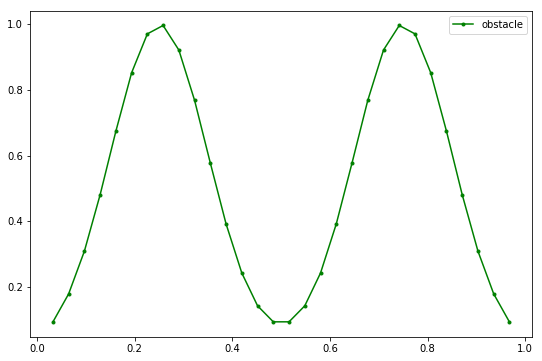

In [6]:
# initialiser les variables K,Q, x0, fmin
N = 30
T = np.linspace(0,1,N+2)[1:-1]
F = np.exp(-50*(T-.75)**2) + np.exp(-50*(T-.25)**2)
plt.plot(T,F,'.-g',label='obstacle')
plt.legend()

Q = 2*np.eye(N) - np.diag(np.ones(N-1),-1)- np.diag(np.ones(N-1),+1)
def projK(x):
    return np.maximum(x,F)

def J(x):
    return .5*np.dot(np.dot(Q,x),x)
def gradJ(x):
    return np.dot(Q,x)
check_gradient(J,gradJ,np.random.rand(N))


On rappelle que l'algorithme du gradient projeté est défini de la manière suivante:

$$ \begin{cases}
x^{(0)} \in \Rsp^N\\
x^{(k+1)} = p_K(x^{(k)} - \tau \nabla J(x^{(k)}))
\end{cases} $$

où $\tau>0$. On a démontré en cours que si 

$$ \forall x\in \Rsp^M, m \leq \D^2 J(x) \leq M, $$

alors l'algorithme converge dès que $\tau < 2m/M^2$, avec un taux optimal lorsque $\tau^* = m/M^2$.

**Q2)** Montrer que $\D^2 J(x) = Q$; calculer les valeurs propres de $Q$ via la fonction np.linalg.eigvalsh. Quelle valeur de $\tau^*$ l'estimation ci-dessus donne-t-elle ? 

In [7]:
eigv = np.linalg.eigvalsh(Q)
M = np.max(eigv)
m = np.min(eigv)
print('taux optimal (theoreme du cours): %g' %  (m/M**2))


taux optimal (theoreme du cours): 0.000644638


**Q3)** Écrire une boucle réalisant l'algorithme du gradient projeté (pour $1\leq k\leq 1000$), et stockant le vecteur $G=(\nr{x^{(k+1)} - x^{(k)}})$ (comme il s'agit d'un algorithme de point fixe, c'est une bonne manière de quantifier la convergence). Tracer la solution $x \in \Rsp^N$ trouvée toutes les 20 itérations (on suggère plt.plot(T,x)).  Tester pour $\tau = \tau^*$. En pratique, vérifier que l'algorithme converge toujours pour des valeurs de $\tau$ plus grandes.

In [11]:
x = np.zeros(N)
tau = m/M**2
G = []
for i in range(5000):
    xp = projK(x - tau*gradJ(x))
    #xp = projK(np.linalg.solve(np.eye(N) + tau*Q, x))
    G.append(np.linalg.norm(xp - x))
    x = xp
    if i%20==0:
        plt.plot(np.hstack((0,T,1)),np.hstack((0,x,0)))
plt.figure()
plt.semilogy(G,label='|x^(k+1) - x^(k)')
plt.legend()


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


ValueError: all the input arrays must have same number of dimensions

**Q4**) Comme $\nabla J(x) = Q$, l'algorithme peut en fait être décrit par

$$ \begin{cases}
x^{(0)} \in \Rsp^N\\
x^{(k+1)} = p_K(A_\tau x^{(k)}) 
\end{cases} $$

où $A_\tau = \mathrm{Id}_N - \tau Q$. Montrer que si toutes les valeurs propres de $A_\tau$ sont de module $<1$, alors l'application $x\mapsto A_\tau x$ est contractante. Vérifier numériquement ce critère pour $\tau=0.5$ (on utilisera np.linalg.eigvalsh pour calculer les valeurs propres).

In [9]:
tau = .5
M = np.eye(N) - tau*Q
np.max(np.abs(np.linalg.eigvalsh(M)))


0.9948693233918954

**Q5)** Comparer la méthode du gradient projeté à celle où on pénalise la contrainte: 

$$P_\eps := \min_{x\in\Rsp^d} J_\eps(x) \hbox{ où } J_\eps(x) = J(x) + \frac{1}{\eps} \sum_{1\leq i\leq N} \max(F_i - x_i,0)^2. $$

Écrire deux fonctions Jeps/gradJeps calculant $J_\eps/\nabla J_\eps$. Vérifier le calcul du gradient en utilisant check_gradient. Résoudre le problème $P_\eps$ par descente de gradient avec backtracking pour $\eps=1,0.1,0.01,0.001$. Interpréter l'explosion du nombre d'itérations.

In [118]:
def Jeps(x,eps):
    N = len(x)
    e = x[0]**2 + x[N-1]**2
    for i in range(0,N-1):
        e += (x[i+1]-x[i])**2
    return J(x) + (1./eps)*np.sum(np.maximum(F-x,0)**2)
def gradJeps(x,eps):
    return gradJ(x) - (2./eps)*np.maximum(F-x,0)
    
x0 = np.random.rand(N)
check_gradient(lambda x: Jeps(x,1), 
               lambda x: gradJeps(x,1),x0)

for eps in [1,0.1]:
    xx,ff,gg = gradient_backtracking(lambda x: Jeps(x,eps), 
                                     lambda x: gradJeps(x,eps), np.zeros(N),err=1e-4)
    print('eps=%g: nb iterations=%d' % (eps, len(gg)))


erreur numerique dans le calcul du gradient: 1.46582e-11 (doit etre petit)
eps=1: nb iterations=364
erreur: nombre maximum d'itérations atteint
eps=0.1: nb iterations=500


## Partie II: Projection sur le simplexe, application à l'optimisation de portefeuilles

Comme dans le TD, on pose $\Delta = \{ x\in \Rsp_+^n \mid \sum_{1\leq i \leq n} x_i = 1\}$. On cherche à calculer la projection d'un point $y\in\Rsp^n$ sur $\Delta$. Dans le TD, on a pu démontrer le résultat suivant:

- il existe $\kappa\in\Rsp$ tel que $\sum_{1\leq i\leq n} \max(y_i - \kappa, 0) = 1$
- la projection de $y$ sur $\Delta$ s'écrit alors $p_\Delta(y) = (\max(y_i - \kappa, 0))_{1\leq i\leq n}$

**Q1)** Soit $y = (0.1,1.5,2.1) \in \Rsp^3$. Écrire une fonction $g(\kappa) := \sum_{1\leq i\leq n} \max(y_i - \kappa,0) - 1$ (utiliser np.sum et np.maximum). Trouver $\kappa$ vérifiant $g(\kappa) = 1$ en utilisant scipy.optimize.fsolve. 

**Q2)** En s'inspirant du code de la fonction précédente, écrire une fonction proj_simplexe calculant la projection d'un point $y\in\Rsp^n$ sur $\Delta$. Pour vérifier le bon fonctionnement de cette fonction, fixez $y\in\Rsp^3$ et calculer $p=$proj_simplexe(y); vérifier ensuite que 

$$ \forall z \in \Delta, \sca{y - p_\Delta(y)}{p_\Delta(y) - z} \geq 0 $$

Comme il ne s'agit bien sûr pas de considérer *tous* les points dans le simplexe, on pourra choisir quelques $z$ aléatoires dans $\Delta$. (dans le cas $n=2$, on peut également tirer quelques points aléatoirement dans le plan et visualiser le segment qui les relie à leur projection sur $\Delta$)

[ 0.938359]
0.33905209183
0.402334379417
0.312095058026
0.344208818507
0.28165873818
0.280881122466
0.470523357576
0.00383768171261
0.193631560168
0.333615225286


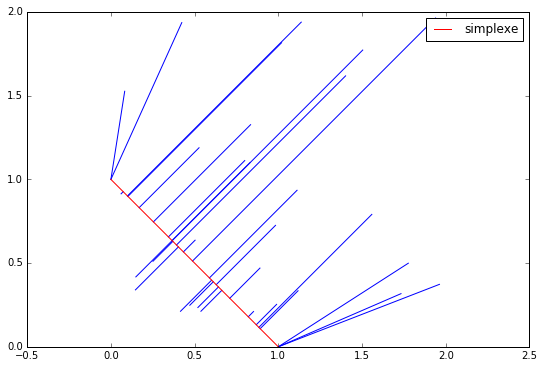

In [124]:
import scipy.optimize

y = np.array([0.1,1.5,2.1])
g = lambda k: np.sum(np.maximum(x-k,0)) - 1.0
k = scipy.optimize.fsolve(g,0)
print(k)


def proj_simplexe(y):
    g = lambda k: np.sum(np.maximum(y-k,0)) - 1.0
    k = scipy.optimize.fsolve(g,0)
    return np.maximum(y-k,0)

# validation: calcul de produits scalaires
y = 4*np.random.rand(3)
p = proj_simplexe(y)
for i in range(10):
    z = np.random.rand(3)
    z = z/np.sum(z)
    print(np.dot(y-p, p-z))

# validation: affichage de projections
plt.figure()
for i in range(30):
    y = 2*np.random.rand(2)
    p = proj_simplexe(y)
    plt.plot([y[0],p[0]],[y[1],p[1]],'b')
    plt.axis('equal')
plt.plot([0,1],[1,0],'r',label='simplexe')
plt.legend()



**Q3)** Implémenter l'algorithme du gradient projeté pour résoudre le problème (en dimension $n=8$):

$$ \min_{x \in \Delta} \frac{1}{2} \sca{Q x}{x} + \frac{1}{2\eps} (\sca{r}{x} - \bar{r})^2 $$

où $Q,r,\bar{r}$ et $\eps$ sont donnés ci-dessous. (On pourra estimer le paramètre $\tau$ de l'algorithme du gradient projeté par tâtonnement, ou comme dans la partie précédente.)

In [125]:
A = np.random.rand(8,8)
Q = np.eye(8) + 0.1*np.dot(A.T,A)
r = np.random.rand(8)
rbar = 0.7*np.max(r)  + 0.3*np.min(r)
eps = 0.1

# on veut trouver la stratégie qui fournit un rendement égal à 70% du rendement du meilleur produit, 
# tout en minimisant le risque

M = Q + np.dot(r.reshape(8,1), r.reshape(1,8))/eps

print(np.abs(np.linalg.eigvalsh(np.eye(8)-tau*M)))



[ 12.02460744   0.28833224   0.43137605   0.45364963   0.46633244
   0.48051341   0.49474769   0.49895256]
